# Cracking the Code to Martian Energy: The search for Uranium in Mars using Gamma Ray Maps

In [1]:
!pip install git+https://github.com/jluttine/d3py.git@develop
!pip install pandas
!pip install numpy
!pip install networkx
!pip install basemap

  Cloning https://github.com/jluttine/d3py.git (to revision develop) to /tmp/pip-req-build-wkd9lzez
  Running command git clone --filter=blob:none --quiet https://github.com/jluttine/d3py.git /tmp/pip-req-build-wkd9lzez
  Resolved https://github.com/jluttine/d3py.git to commit 2856eb3aa23c4ae17897fcd6a25b68203eb1e9e0
  Preparing metadata (setup.py) ... done
  Created wheel for d3py: filename=d3py-0.0.0.dev20250313-py3-none-any.whl size=5461 sha256=51aa4dee7c6bc549a73e5ed6edef72d72c468938b3155726a3e24ff8dec1a308
  Stored in directory: /tmp/pip-ephem-wheel-cache-w3if1us9/wheels/a8/1d/d8/3e81fd97f20ca470462ffce9ababd405877cdc366e03f5f495
Successfully built d3py
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 942.4/942.4 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━

In [4]:
## Download Th and K concentration data from https://ode.rsl.wustl.edu/mars/DataSetExplorer.aspx?target=mars&instrumenthost=ODY&instrumentid=GRS&datasetid=ODY-M-GRS-5-ELEMENTS-V1.0&volumeid=ODGM_XXXX&pathtovol=data/unsmoothed/2x2/
## set path to the parent directory of the data
from google.colab import drive;
drive.mount("/content/drive/")
path = '/content/drive/MyDrive/Synopsys/2025/project_code/data/mars'

Mounted at /content/drive/


In [5]:
# Importing necessary libraries

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image
from pandas.core.frame import DataFrame
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from typing import List

In [6]:
def convert_file_to_dataframe(filepath: str, column_names: List[str]) -> DataFrame:
    """
    This function reads the space-seperated file and loads it as a pandas dataframe

    Args:
        filepath: path to files containing concentration levels; contains space-seperated files
        column_names: the column names corresponding to the table

    Returns:
        The content of the csv file as a dataframe
    """
    df = pd.read_csv(filepath, sep = '\s+', header = None, names = column_names)
    return df

In [7]:
"""
    Preparing for joining K and Th data which are in different files based on latitude and longitude.
    I am intentionally keeping the non-key
    (columns other than "latitude" and "longitude") column names
    different for potassium and thorium
    since those are the only two columns that will be merged
    once the joined dataframe is created
"""
# Potassium Column names
K_COLUMN_NAMES = ["latitude", "longitude", "k_concentration", "k_error", "k_error_with_cfs"]

# Thorium Column names
TH_COLUMN_NAMES = ["latitude", "longitude", "th_concentration", "th_error", "th_error_with_cfs"]

k_df = convert_file_to_dataframe(f"{path}/Potassium_concentration/k_2x2.tab.txt", K_COLUMN_NAMES)
th_df = convert_file_to_dataframe(f"{path}/Thorium_concentration/th_2x2.tab.txt", TH_COLUMN_NAMES)

In [8]:
# I am joining potassium and thorium dataframes using the latitude and longitude as join keys (columns I am trying to match on)
# I am using inner join - a type of join where only the matching rows that are in the left and right dataframes will be in the joined dataframe
joined_df = pd.merge(k_df, th_df, on = ['latitude', 'longitude'], how = 'inner')
joined_df

,latitude,longitude,k_concentration,k_error,k_error_with_cfs,th_concentration,th_error,th_error_with_cfs
0,-87,1,-0.019,0.184,9999.999,-0.000142,0.000100,9999.999
1,-87,3,0.161,0.166,9999.999,-0.000107,0.000098,9999.999
2,-87,5,0.006,0.198,9999.999,0.000043,0.000104,9999.999
3,-87,7,0.248,0.178,9999.999,0.000174,0.000106,9999.999
4,-87,9,-0.167,0.199,9999.999,0.000188,0.000109,9999.999
...,...,...,...,...,...,...,...,...
15835,87,351,0.211,0.147,9999.999,-0.000050,0.000080,9999.999
15836,87,353,-0.186,0.163,9999.999,0.000138,0.000083,9999.999
15837,87,355,-0.003,0.171,9999.999,-0.000039,0.000088,9999.999
15838,87,357,0.064,0.159,9999.999,-0.000054,0.000085,9999.999


In [9]:

"""
# I created a copy of the joined dataframe so that I could make alterations
# and still keep the original joined dataframe
"""
correct_df = joined_df.copy(deep = True)

"""
    DATA CLEANING:
    In the input data for potassium and thorium concentration, there were some negative values,
    which meant that the concentration values were too low for the GRS to detect.
    To make sure that the results for the uranium concentration values weren't affected,
    I replaced all those negative values with 0.
    The error values also needed to be adjusted after changing the concentration to 0, so I found the minimum value in each column:
    k_error, k_error_with_cfs, th_error, th_error_with_cfs,
    and replaced the values with those minimum values in the error rows where the concentrations were negative.

    Note:
        I tried proportional scaling and used the formula:
        error = error * (1 - concentration_after_change) / original_concentration,
        where concentration_after_change was 0.
        However, after analyzing the scaled error values, I found that the error values were scaled very high,
        and resulted in outliers in the data.
        This is why I used another approach: to find the minimum value in each column overall
        and replace the appropriate values (where the concentrations were negative) with the minimum values.
"""

# Minimum values found in each column
min_k_error = correct_df['k_error'].min()
print(min_k_error)

min_th_error  = correct_df['th_error'].min()
print(min_th_error)


correct_df['adj_k_error'] = np.where(correct_df['k_concentration'] < 0,
                                 min_k_error, correct_df['k_error'])

correct_df['adj_th_error'] = np.where(correct_df['th_concentration'] < 0,
                                 min_th_error, correct_df['th_error'])

correct_df['adj_k_concentration'] = np.where(correct_df['k_concentration'] < 0,
                                         0, correct_df['k_concentration'])

correct_df['adj_th_concentration'] = np.where(correct_df['th_concentration'] < 0,
                                          0, correct_df['th_concentration'])

correct_df

0.049
3.3e-05


,latitude,longitude,k_concentration,k_error,k_error_with_cfs,th_concentration,th_error,th_error_with_cfs,adj_k_error,adj_th_error,adj_k_concentration,adj_th_concentration
0,-87,1,-0.019,0.184,9999.999,-0.000142,0.000100,9999.999,0.049,0.000033,0.000,0.000000
1,-87,3,0.161,0.166,9999.999,-0.000107,0.000098,9999.999,0.166,0.000033,0.161,0.000000
2,-87,5,0.006,0.198,9999.999,0.000043,0.000104,9999.999,0.198,0.000104,0.006,0.000043
3,-87,7,0.248,0.178,9999.999,0.000174,0.000106,9999.999,0.178,0.000106,0.248,0.000174
4,-87,9,-0.167,0.199,9999.999,0.000188,0.000109,9999.999,0.049,0.000109,0.000,0.000188
...,...,...,...,...,...,...,...,...,...,...,...,...
15835,87,351,0.211,0.147,9999.999,-0.000050,0.000080,9999.999,0.147,0.000033,0.211,0.000000
15836,87,353,-0.186,0.163,9999.999,0.000138,0.000083,9999.999,0.049,0.000083,0.000,0.000138
15837,87,355,-0.003,0.171,9999.999,-0.000039,0.000088,9999.999,0.049,0.000033,0.000,0.000000
15838,87,357,0.064,0.159,9999.999,-0.000054,0.000085,9999.999,0.159,0.000033,0.064,0.000000


In [10]:
"""
I tried out 4 different prediction functions and looked at the predicted likelihood of uranium.
In all the functions, I adjusted the prediction based on the corresponding error propagation.
In the final result, I used the weighted average, as it was a much more meaningful function based on my analysis.

The four functions were:
    1. Weighted average of Potassium and Thorium based on distributions found in Earth
        - On Earth: Thorium is about 3 times more abundant than Uranium (Th:U = 3:1), and
          Potassium is about 10,000 times more abundant than Uranium (K:U = 10000:1)
    2. Simple Average of Potassium and Thorium
        - I give equal weights to Potassium and Thorium
    3. Potassium only
        - I only considered Potassium
    4. Thorium only
        - I only considered Thorium
"""

#Weighted
correct_df['p_u_c_w'] = (0.0001 * correct_df['adj_k_concentration'] + 0.3333 * correct_df['adj_th_concentration']) / 2
correct_df['p_u_c_w_error'] = np.sqrt(np.power(0.0001 * correct_df['adj_k_error'], 2) + np.power(0.3333 * correct_df['adj_th_error'], 2))

#unweighted
correct_df['p_u_c'] = (correct_df['adj_k_concentration'] + correct_df['adj_th_concentration']) / 2
correct_df['p_u_c_error'] = np.sqrt((np.power(correct_df['adj_k_error'], 2) + np.power(correct_df['adj_th_error'], 2)) / 4)

# K_only
correct_df['p_u_c_k_only'] = correct_df['adj_k_concentration']
correct_df['p_u_c_k_only_error'] = correct_df['adj_k_error']

#th_only
correct_df['p_u_c_th_only'] = correct_df['adj_th_concentration']
correct_df['p_u_c_th_only_error'] = correct_df['adj_th_error']

correct_df

,latitude,longitude,k_concentration,k_error,k_error_with_cfs,th_concentration,th_error,th_error_with_cfs,adj_k_error,adj_th_error,adj_k_concentration,adj_th_concentration,p_u_c_w,p_u_c_w_error,p_u_c,p_u_c_error,p_u_c_k_only,p_u_c_k_only_error,p_u_c_th_only,p_u_c_th_only_error
0,-87,1,-0.019,0.184,9999.999,-0.000142,0.000100,9999.999,0.049,0.000033,0.000,0.000000,0.000000,0.000012,0.000000,0.0245,0.000,0.049,0.000000,0.000033
1,-87,3,0.161,0.166,9999.999,-0.000107,0.000098,9999.999,0.166,0.000033,0.161,0.000000,0.000008,0.000020,0.080500,0.0830,0.161,0.166,0.000000,0.000033
2,-87,5,0.006,0.198,9999.999,0.000043,0.000104,9999.999,0.198,0.000104,0.006,0.000043,0.000007,0.000040,0.003021,0.0990,0.006,0.198,0.000043,0.000104
3,-87,7,0.248,0.178,9999.999,0.000174,0.000106,9999.999,0.178,0.000106,0.248,0.000174,0.000041,0.000040,0.124087,0.0890,0.248,0.178,0.000174,0.000106
4,-87,9,-0.167,0.199,9999.999,0.000188,0.000109,9999.999,0.049,0.000109,0.000,0.000188,0.000031,0.000037,0.000094,0.0245,0.000,0.049,0.000188,0.000109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15835,87,351,0.211,0.147,9999.999,-0.000050,0.000080,9999.999,0.147,0.000033,0.211,0.000000,0.000011,0.000018,0.105500,0.0735,0.211,0.147,0.000000,0.000033
15836,87,353,-0.186,0.163,9999.999,0.000138,0.000083,9999.999,0.049,0.000083,0.000,0.000138,0.000023,0.000028,0.000069,0.0245,0.000,0.049,0.000138,0.000083
15837,87,355,-0.003,0.171,9999.999,-0.000039,0.000088,9999.999,0.049,0.000033,0.000,0.000000,0.000000,0.000012,0.000000,0.0245,0.000,0.049,0.000000,0.000033
15838,87,357,0.064,0.159,9999.999,-0.000054,0.000085,9999.999,0.159,0.000033,0.064,0.000000,0.000003,0.000019,0.032000,0.0795,0.064,0.159,0.000000,0.000033


In [11]:
correct_df.to_csv(f'{path}/merged.csv', index = False)

In [ ]:
"""
Ran Clustering on the predicted uranium concentration using KMeans, DBSCAN, and Hierarchical Clustering.
All three clustering methods produced similar results showing higher uranium concentration in the same areas.

adj_k_concentration and adj_th_concentration - the cleaned data for potassium and thorium.
p_u_c_w - the predicted uranium concentration using the weighted average of potassium and thorium..
p_u_c_w_error - the error in the predicted uranium concentration using the weighted average of potassium and thorium.

Before running the clustering, I included the error values in the data by adding a random perturbation to the data.

"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import matplotlib.pyplot as plt

#Weighted
correct_df['p_u_c_w'] = (0.0001 * correct_df['adj_k_concentration'] + 0.3333 * correct_df['adj_th_concentration']) / 2
correct_df['p_u_c_w_error'] = np.sqrt(np.power(0.0001 * correct_df['adj_k_error'], 2) + np.power(0.3333 * correct_df['adj_th_error'], 2))

#unweighted
correct_df['p_u_c'] = (correct_df['adj_k_concentration'] + correct_df['adj_th_concentration']) / 2
correct_df['p_u_c_error'] = np.sqrt((np.power(correct_df['adj_k_error'], 2) + np.power(correct_df['adj_th_error'], 2)) / 4)

# K_only
correct_df['p_u_c_k_only'] = correct_df['adj_k_concentration']
correct_df['p_u_c_k_only_error'] = correct_df['adj_k_error']

#th_only
correct_df['p_u_c_th_only'] = correct_df['adj_th_concentration']
correct_df['p_u_c_th_only_error'] = correct_df['adj_th_error']
df = correct_df

"""
Standardize the data: Normalizing (scaling) the data so their range is from 0 - 1
"""
perturbation_factor = 0.01
cols = ['p_u_c_w']
for c in cols:
    # we determined the optimal k through elbow method.
    optimal_k = 8
    # Cluster id corresponding to areas where measurement was negative.
    unknown_area_cluster = optimal_k * 2
    X = df[[c]].values
    # adjust with error values
    X = X + np.random.normal(0, df[f'{c}_error'].values * perturbation_factor)
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)

    # K-Means Clustering
    print(f"K-Means Clustering for {c}")
    kmeans = KMeans(n_clusters=optimal_k, random_state=11)
    df[f'cluster_kmeans_{c}'] = kmeans.fit_predict(X_std)
    average_concentrations_kmeans = df.groupby(f'cluster_kmeans_{c}')[c].mean().rename(f'cluster_rank_kmeans_{c}')
    cluster_ranks_kmeans = average_concentrations_kmeans.rank()
    cluster_ranks_df_kmeans = cluster_ranks_kmeans.reset_index()
    df = df.merge(cluster_ranks_df_kmeans, on=f'cluster_kmeans_{c}', how='left')
    df[f'cluster_rank_1_kmeans_{c}'] = np.where((df[f'cluster_rank_kmeans_{c}'] < optimal_k) & (df[f'cluster_rank_kmeans_{c}'] > 0), 0, df[f'cluster_rank_kmeans_{c}'])
    df[f'cluster_rank_new_kmeans_{c}'] = np.where((df['k_concentration'] < 0) & (df['th_concentration'] < 0), unknown_area_cluster, df[f'cluster_rank_1_kmeans_{c}'])

    # DBSCAN Clustering
    print(f"DBSCAN Clustering for {c}")
    dbscan = DBSCAN(eps=0.5, min_samples=10)  # Adjust eps and min_samples as needed
    df[f'cluster_dbscan_{c}'] = dbscan.fit_predict(X_std)
    unique_labels_dbscan = np.unique(df[f'cluster_dbscan_{c}'])
    average_concentrations_dbscan = df.groupby(f'cluster_dbscan_{c}')[c].mean().rename(f'cluster_rank_dbscan_{c}')
    cluster_ranks_dbscan = average_concentrations_dbscan.rank()
    cluster_ranks_df_dbscan = cluster_ranks_dbscan.reset_index()
    df = df.merge(cluster_ranks_df_dbscan, on=f'cluster_dbscan_{c}', how='left')
    df[f'cluster_rank_1_dbscan_{c}'] = np.where((df[f'cluster_rank_dbscan_{c}'] < optimal_k) & (df[f'cluster_rank_dbscan_{c}'] > 0), 0, df[f'cluster_rank_dbscan_{c}'])
    df[f'cluster_rank_new_dbscan_{c}'] = np.where((df['k_concentration'] < 0) & (df['th_concentration'] < 0), unknown_area_cluster, df[f'cluster_rank_1_dbscan_{c}'])

    # Hierarchical Clustering
    print(f"Hierarchical Clustering for {c}")
    agg_clustering = AgglomerativeClustering(n_clusters=optimal_k)
    df[f'cluster_hierarchical_{c}'] = agg_clustering.fit_predict(X_std)
    average_concentrations_hierarchical = df.groupby(f'cluster_hierarchical_{c}')[c].mean().rename(f'cluster_rank_hierarchical_{c}')
    cluster_ranks_hierarchical = average_concentrations_hierarchical.rank()
    cluster_ranks_df_hierarchical = cluster_ranks_hierarchical.reset_index()
    df = df.merge(cluster_ranks_df_hierarchical, on=f'cluster_hierarchical_{c}', how='left')
    df[f'cluster_rank_1_hierarchical_{c}'] = np.where((df[f'cluster_rank_hierarchical_{c}'] < optimal_k) & (df[f'cluster_rank_hierarchical_{c}'] > 0), 0, df[f'cluster_rank_hierarchical_{c}'])
    df[f'cluster_rank_new_hierarchical_{c}'] = np.where((df['k_concentration'] < 0) & (df['th_concentration'] < 0), unknown_area_cluster, df[f'cluster_rank_hierarchical_{c}'])

    num_unknown = (df[f'cluster_rank_new_kmeans_{c}'] == unknown_area_cluster).sum()
    num_uranium = (df[f'cluster_rank_new_kmeans_{c}'] == optimal_k).sum()
    total = df.shape[0]
    percentage_search = (num_uranium * 100) / total
    percentage_search_with_unknown = ((num_unknown + num_uranium) * 100) / total
    print("Number of regions with no useful data: {0} - {1}".format(num_unknown, c))
    print("Number of regions with highest probabity {0} - {1}".format(num_uranium, c))
    print("Percentage of regions with highest probabity {0} - {1}".format(percentage_search, c))
    print("Percentage of regions with highest probabity and no useful data {0} - {1}".format(percentage_search_with_unknown, c))
    print("Total={}".format(total))


K-Means Clustering for p_u_c_w
DBSCAN Clustering for p_u_c_w
Hierarchical Clustering (Agglomerative) for p_u_c_w
Number of regions with no useful data: 163 - p_u_c_w
Number of regions with highest probabity 202 - p_u_c_w
Percentage of regions with highest probabity 1.2752525252525253 - p_u_c_w
Percentage of regions with highest probabity and no useful data 2.3042929292929295 - p_u_c_w
Total=15840


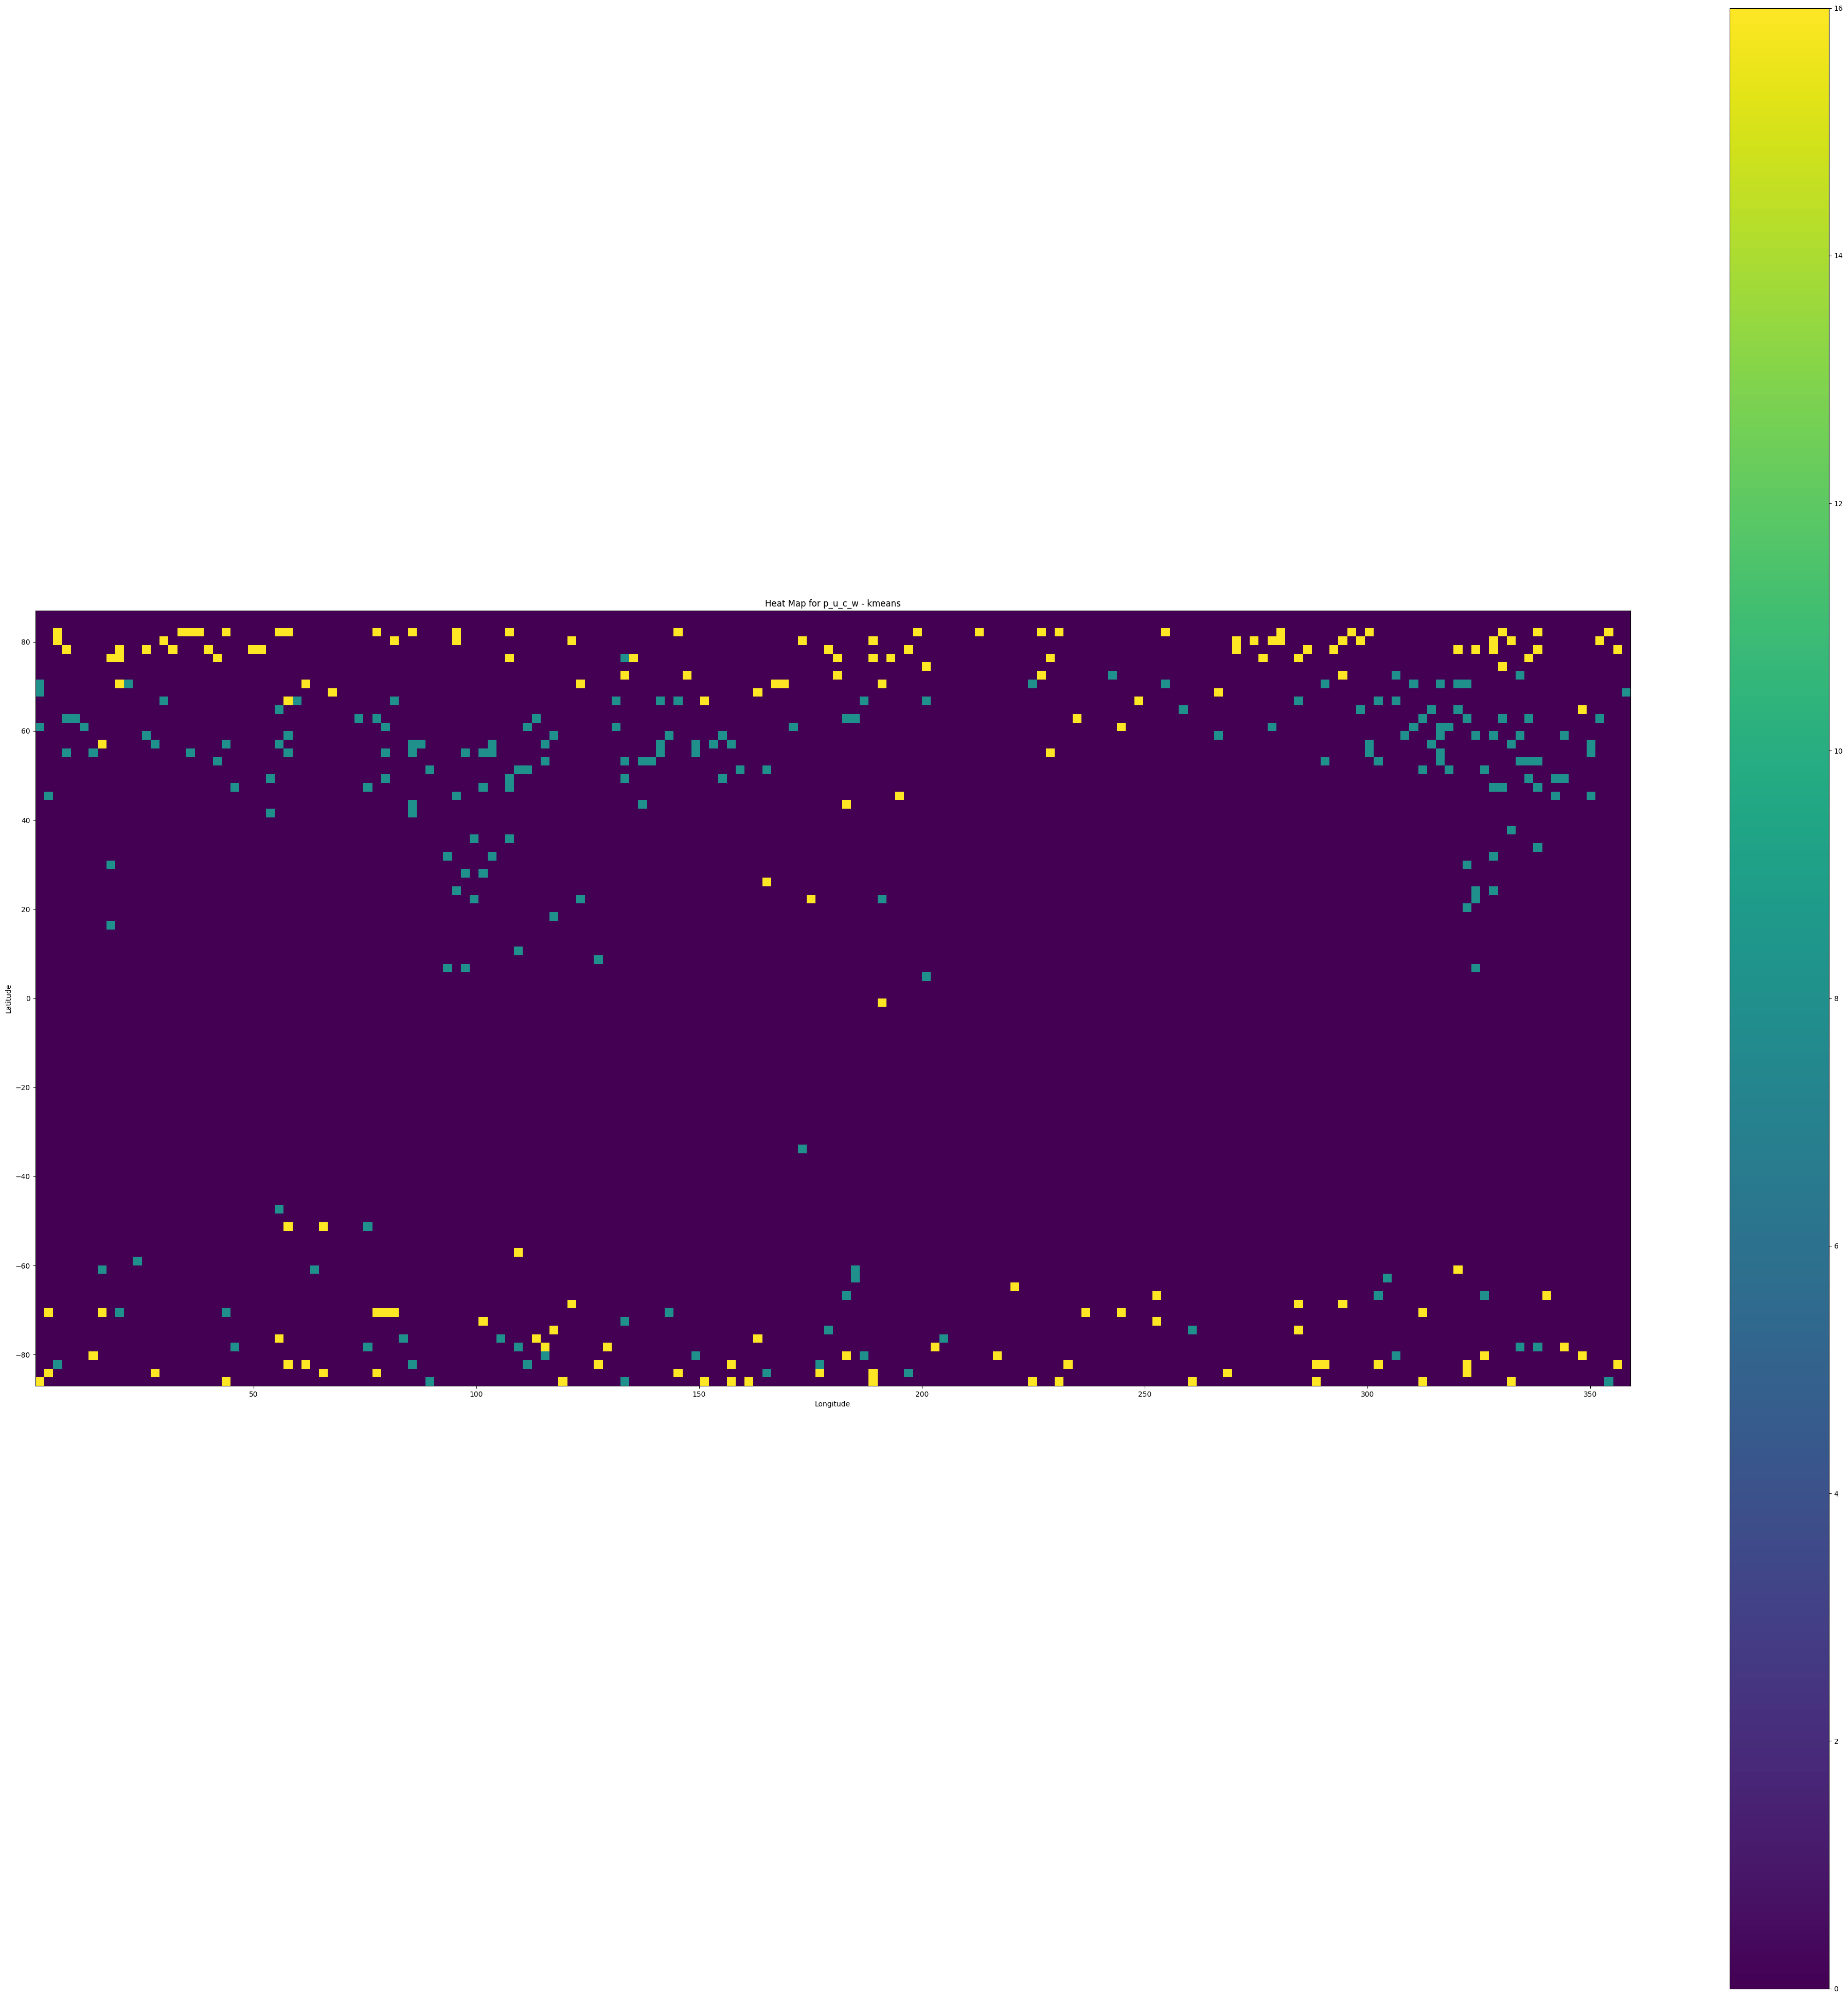

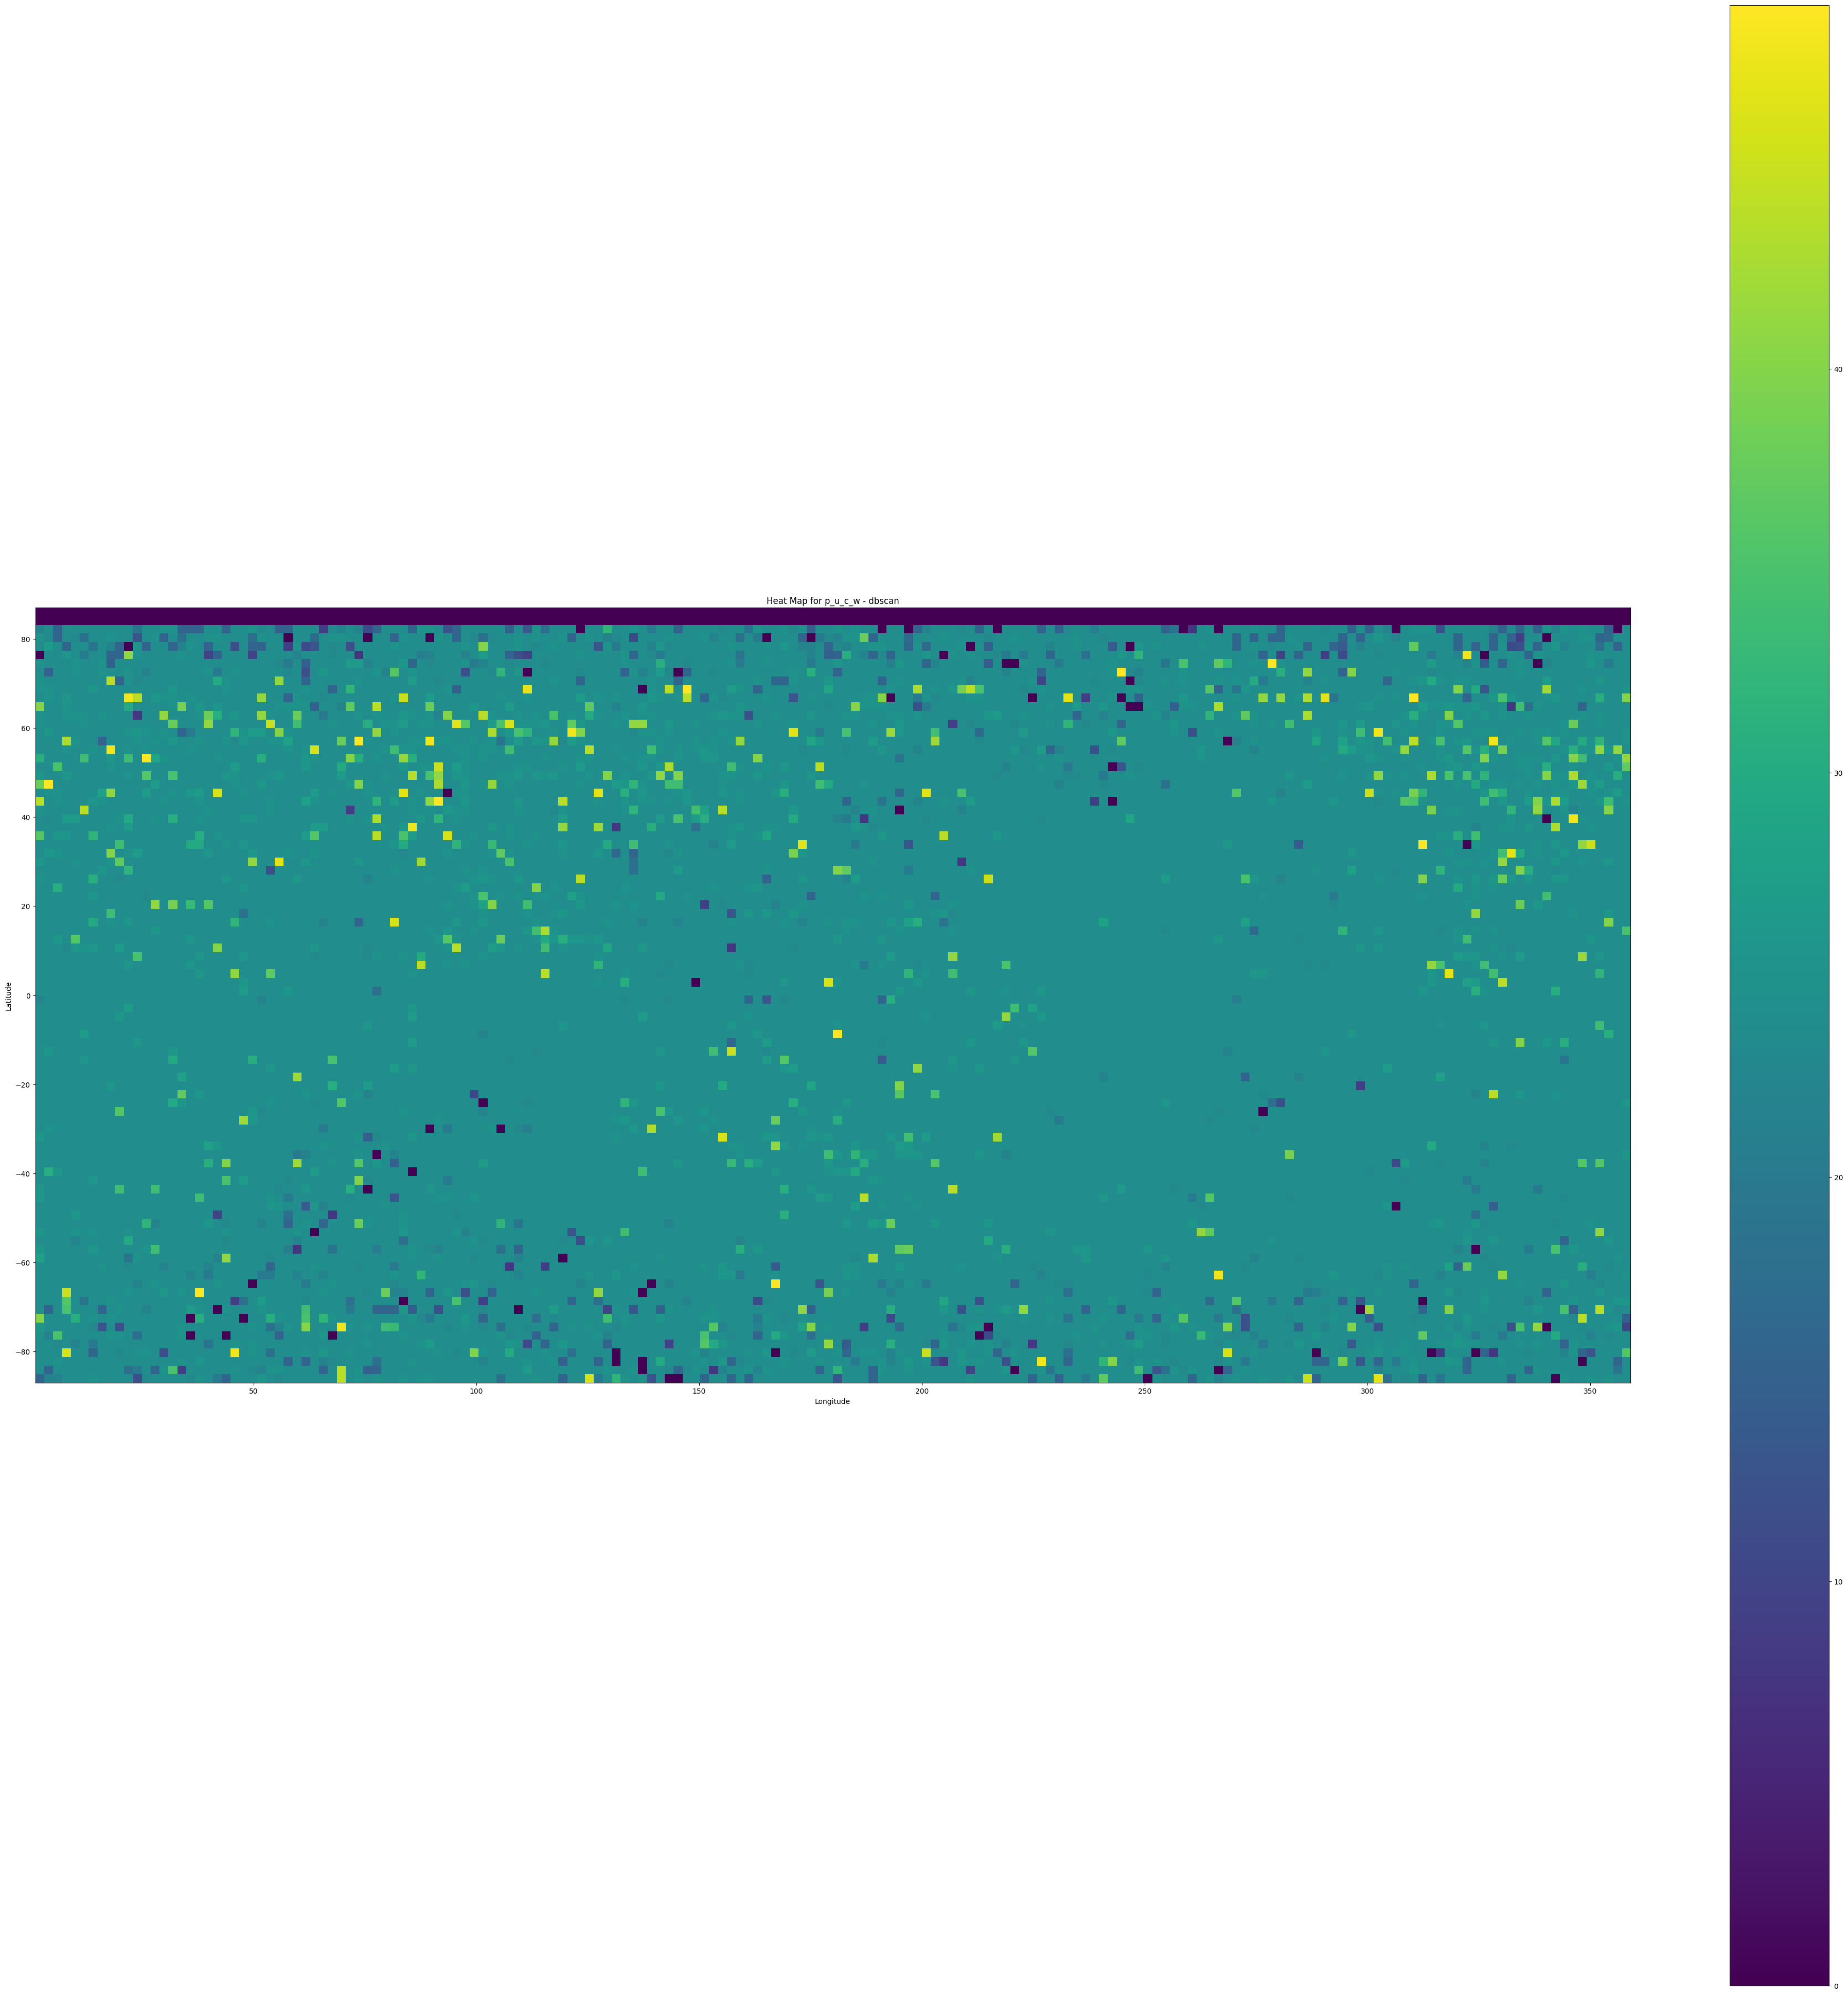

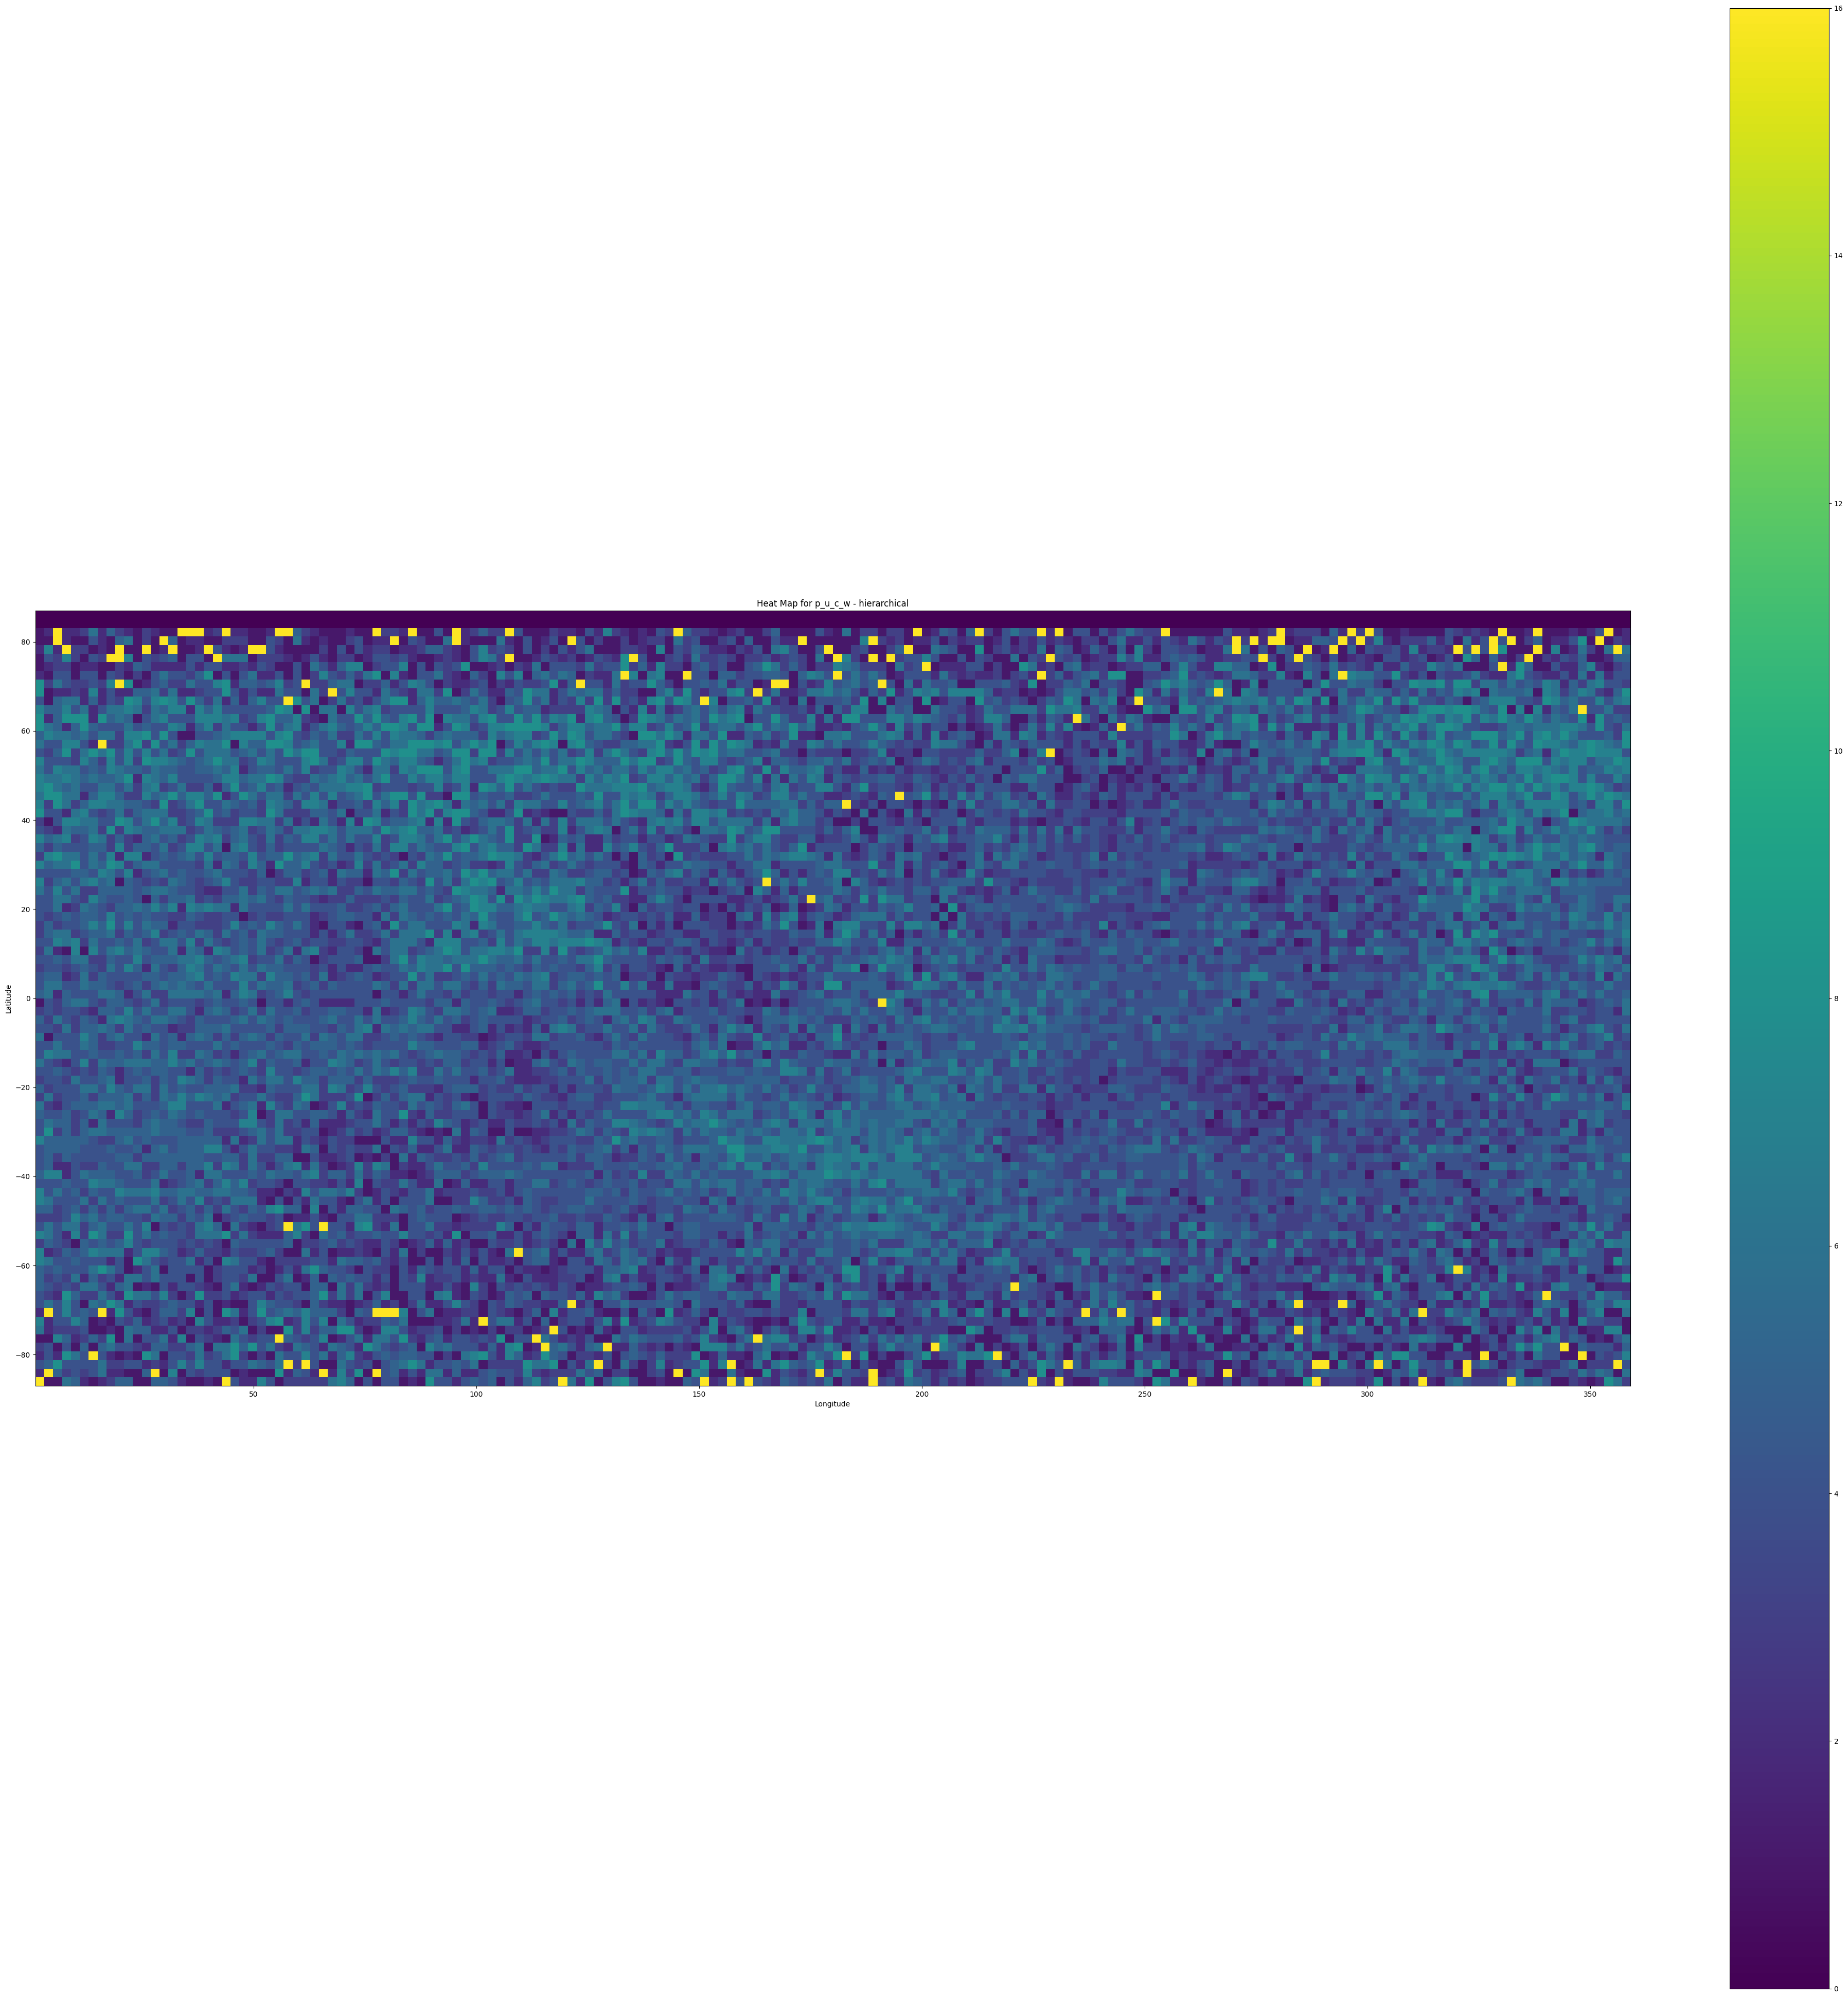

In [ ]:
"""
Visualize the results of the clustering using heatmaps.
"""
import matplotlib.pyplot as plt

unique_lats = sorted(df['latitude'].unique())
unique_lons = sorted(df['longitude'].unique())
latitude_grid = np.linspace(df['latitude'].min(), df['latitude'].max(), 90)
longitude_grid = np.linspace(df['longitude'].min(), df['longitude'].max(), 180)
longitude_mesh, latitude_mesh = np.meshgrid(longitude_grid, latitude_grid)

for c in cols:
    for cluster_type in ['kmeans', 'dbscan', 'hierarchical']:
        cluster_grid = np.zeros_like(latitude_mesh, dtype=int)
        lat_indices = np.searchsorted(unique_lats, df['latitude'])
        lon_indices = np.searchsorted(unique_lons, df['longitude'])
        cluster_grid[lat_indices, lon_indices] = df[f'cluster_rank_new_{cluster_type}_{c}']
        grid_clusters = cluster_grid.reshape(latitude_mesh.shape)

        fig, ax = plt.subplots(1, 1, figsize=(50, 50))
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title(f'Heat Map for {c} - {cluster_type}')

        ims = ax.imshow(grid_clusters, origin='lower',
                       extent=[df['longitude'].min(),
                               df['longitude'].max(),
                               df['latitude'].min(),
                               df['latitude'].max()])

        cbar = fig.colorbar(ims)
        plt.show()

Preparing data for Thorium and Potassium Heatmaps...
Generating Side-by-Side Heatmaps...


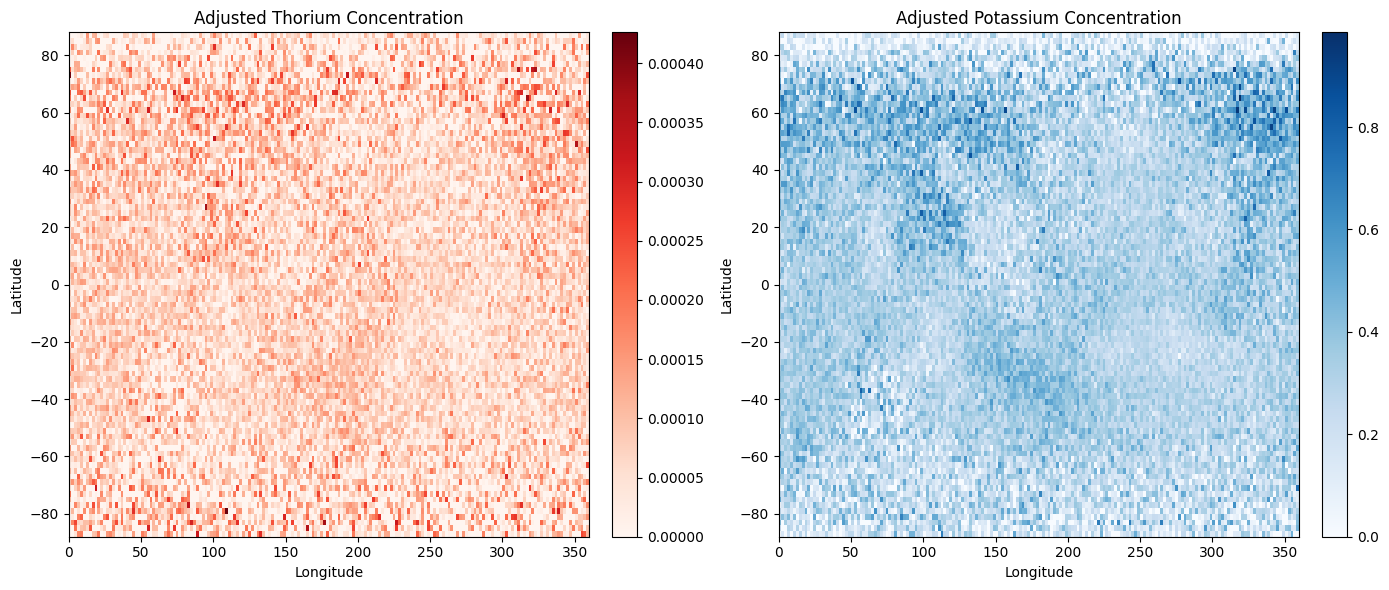

Side-by-side heatmaps for Thorium and Potassium generated. Check plot output.


In [ ]:
"""
Print Heatmaps for Th and K concentration
"""
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm  # For colormaps

print("Preparing data for Thorium and Potassium Heatmaps...")

th_pivot = df.pivot_table(index='latitude', columns='longitude', values='adj_th_concentration')
k_pivot = df.pivot_table(index='latitude', columns='longitude', values='adj_k_concentration')

# Get latitude and longitude values (assuming they are the same for both)
latitude_vals = th_pivot.index.values # Or k_pivot.index.values, they should be the same
longitude_vals = th_pivot.columns.values # Or k_pivot.columns.values

# Convert pivoted tables to NumPy arrays for heatmap plotting
th_grid = th_pivot.values
k_grid = k_pivot.values

# Create meshgrids for longitude and latitude
longitude_mesh, latitude_mesh = np.meshgrid(longitude_vals, latitude_vals)

# Choose Distinct Color Schemes
# For Thorium, let's use a Red-based colormap
thorium_cmap = cm.Reds

# For Potassium, let's use a Blue-based colormap
potassium_cmap = cm.Blues

# reate Side-by-Side Heatmaps using Matplotlib
print("Generating Side-by-Side Heatmaps...")
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) # 1 row, 2 columns of subplots

# --- Heatmap for Thorium (LEFT subplot) ---
im_th = axes[0].pcolormesh(longitude_mesh, latitude_mesh, th_grid, cmap=thorium_cmap) # Thorium cmap
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title('Adjusted Thorium Concentration')
fig.colorbar(im_th, ax=axes[0], fraction=0.046, pad=0.04) # Colorbar for Thorium

# --- Heatmap for Potassium (RIGHT subplot) ---
im_k = axes[1].pcolormesh(longitude_mesh, latitude_mesh, k_grid, cmap=potassium_cmap) # Potassium cmap
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].set_title('Adjusted Potassium Concentration')
fig.colorbar(im_k, ax=axes[1], fraction=0.046, pad=0.04) # Colorbar for Potassium


plt.tight_layout()
plt.show()

print("Side-by-side heatmaps for Thorium and Potassium generated. Check plot output.")

Preparing data for 3D Surface Plot...
Generating 3D Surface Plot with Plotly - High Contrast (Hot)...


Generating 3D Surface Plot with Matplotlib - High Contrast (hot)...


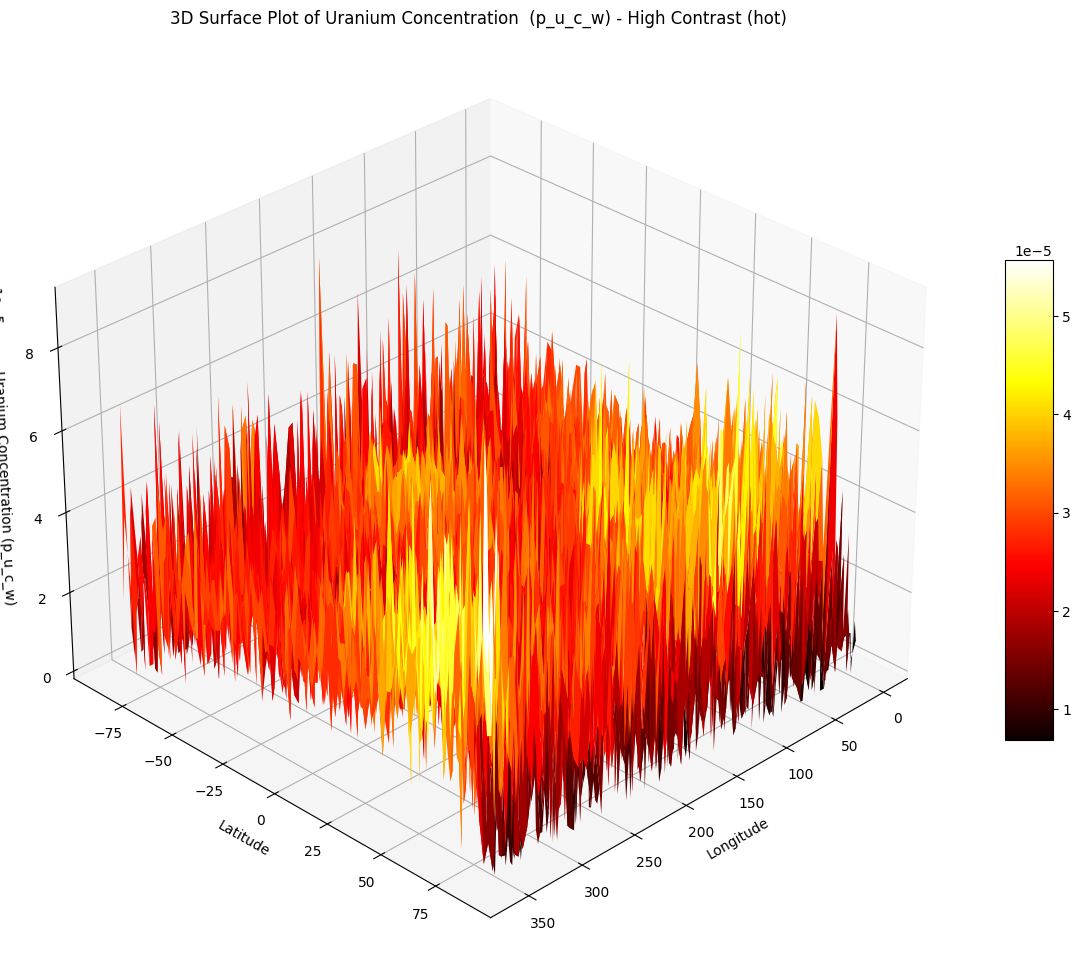

High contrast 3D Surface Plots generated.


In [ ]:
"""
3D Surface Plot for Uranium Concentration
"""
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm # For more colormaps


print("Preparing data for 3D Surface Plot...")
df_pivot = df.pivot_table(index='latitude', columns='longitude', values='p_u_c_w')
latitude_vals = df_pivot.index.values
longitude_vals = df_pivot.columns.values
z_values = df_pivot.values
longitude_mesh, latitude_mesh = np.meshgrid(longitude_vals, latitude_vals)
selected_plotly_colorscale = 'Hot'
selected_matplotlib_cmap = cm.hot

# Create 3D Surface Plot using Plotly
print(f"Generating 3D Surface Plot with Plotly - High Contrast ({selected_plotly_colorscale})...")

fig_surface_plotly_hc = go.Figure(data=[go.Surface(z=z_values,
                                         x=longitude_mesh,
                                         y=latitude_mesh,
                                         colorscale=selected_plotly_colorscale)])
fig_surface_plotly_hc.update_layout(title=f'3D Surface Plot of Uranium Concentration (p_u_c_w) - High Contrast ({selected_plotly_colorscale})',
                         scene = dict(
                             xaxis_title='Longitude',
                             yaxis_title='Latitude',
                             zaxis_title='Uranium Probability (p_u_c_w)'),
                         margin=dict(l=65, r=50, b=65, t=90))

fig_surface_plotly_hc.show()


# Create 3D Surface Plot using Matplotlib
print(f"Generating 3D Surface Plot with Matplotlib - High Contrast ({selected_matplotlib_cmap.name})...")

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')

# Plot the surface
surface_hc = ax.plot_surface(longitude_mesh, latitude_mesh, z_values,
                               cmap=selected_matplotlib_cmap)

# Add color bar which maps values to colors.
fig.colorbar(surface_hc, shrink=0.5, aspect=10)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Uranium Concentration (p_u_c_w)')
ax.set_title(f'3D Surface Plot of Uranium Concentration  (p_u_c_w) - High Contrast ({selected_matplotlib_cmap.name})')
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()


print("High contrast 3D Surface Plots generated.")

In [ ]:
### Preparing Mars Surface Plots

import json

# This is the location where I saved the latitude and longitude for the highest predicted concentration.
loc_json_path = "/content/drive/MyDrive/Synopsys/2025/project_code/data/marsData.json"
marsData = []
with open(loc_json_path, "r") as F:
    marsData = json.loads(F.read())


In [ ]:
!pip install cartopy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 90.6 MB/s eta 0:00:00


In [ ]:
import cartopy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.image as mpimg


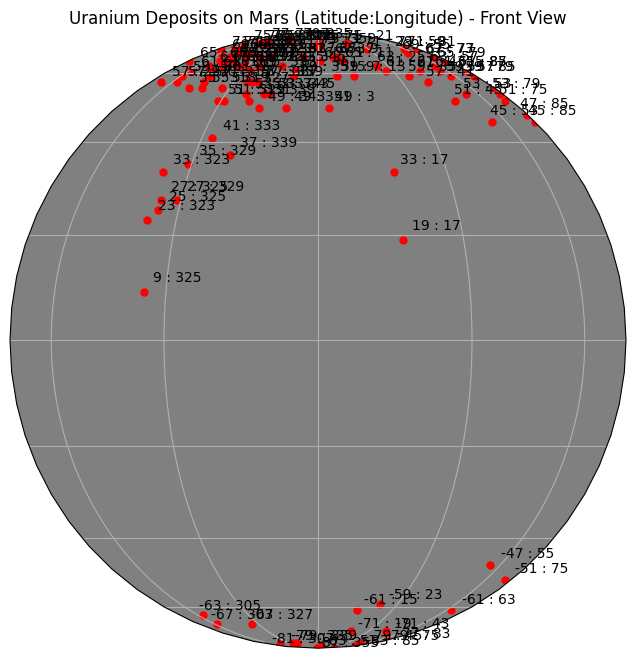

In [ ]:
## Orthographic Projection

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(0, 0))

# Set grey background
ax.set_facecolor('grey')

for point in marsData:
    ax.plot(
        point["lon"],
        point["lat"],
        "ro",
        markersize=5,
        transform=ccrs.Geodetic(),
    )
    ax.text(
        point["lon"] + 2,
        point["lat"] + 2,
        str(point["lat"]) + " : " + str(point["lon"]),
        transform=ccrs.Geodetic(),
    )

ax.set_global()
ax.gridlines()

plt.title("Uranium Deposits on Mars (Latitude:Longitude) - Front View")  # Updated title
plt.show()

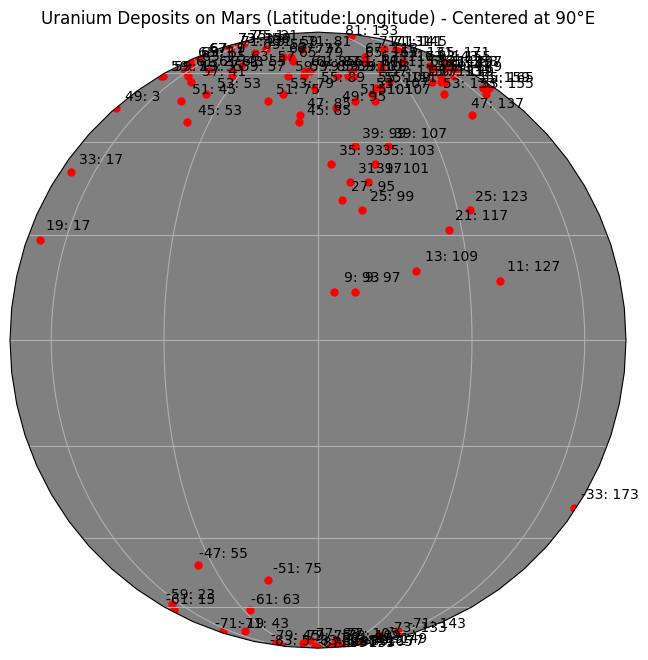

In [ ]:
# Use Orthographic projection with central_longitude set to 90

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig = plt.figure(figsize=(10, 8))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=90))  # Centered at 90 degrees East

# Set grey background
ax.set_facecolor('grey')

for point in marsData:
    ax.plot(
        point["lon"],
        point["lat"],
        "ro",
        markersize=5,
        transform=ccrs.Geodetic(),
    )
    ax.text(
        point["lon"] + 2,
        point["lat"] + 2,
        str(point["lat"]) + ": " + str(point["lon"]),
        transform=ccrs.Geodetic(),
    )

ax.set_global()
ax.gridlines()

plt.title("Uranium Deposits on Mars (Latitude:Longitude) - Centered at 90°E")  # Updated title
plt.show()

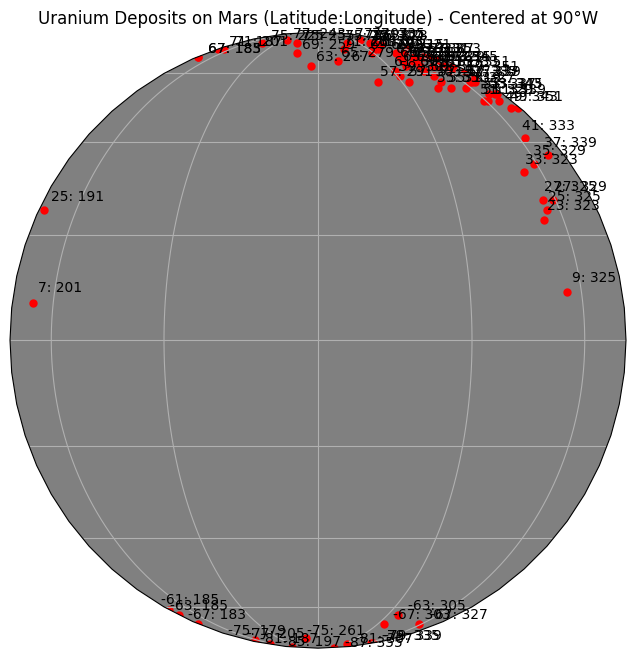

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig = plt.figure(figsize=(10, 8))

# Use Orthographic projection with central_longitude set to -90
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=-90))  # Centered at 90 degrees West

# Set grey background
ax.set_facecolor('grey')

for point in marsData:
    ax.plot(
        point["lon"],
        point["lat"],
        "ro",
        markersize=5,
        transform=ccrs.Geodetic(),
    )
    ax.text(
        point["lon"] + 2,
        point["lat"] + 2,
        str(point["lat"]) + ": " + str(point["lon"]),
        transform=ccrs.Geodetic(),
    )

ax.set_global()
ax.gridlines()

plt.title("Uranium Deposits on Mars (Latitude:Longitude) - Centered at 90°W")  # Updated title
plt.show()

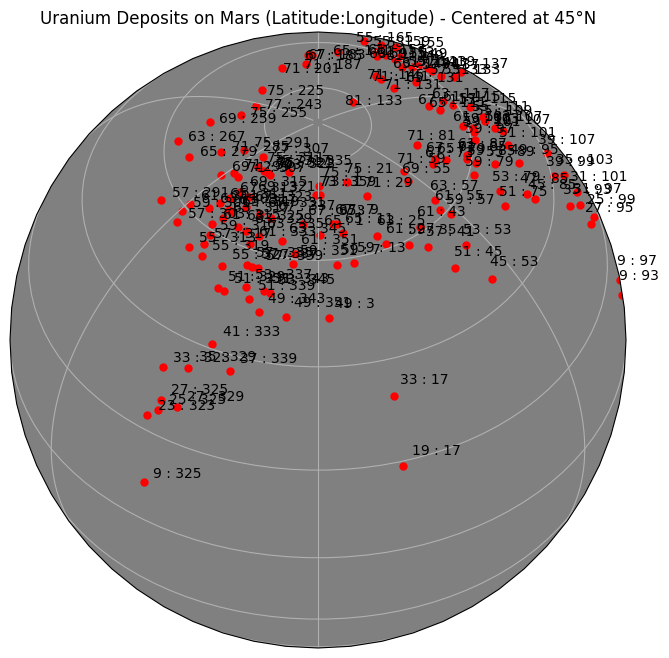

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig = plt.figure(figsize=(10, 8))

# Adjust the central latitude to show more of the North Pole
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(0, 45))  # Centered at 45 degrees North

# Set grey background
ax.set_facecolor('grey')

for point in marsData:
    ax.plot(
        point["lon"],
        point["lat"],
        "ro",
        markersize=5,
        transform=ccrs.Geodetic(),
    )
    ax.text(
        point["lon"] + 2,
        point["lat"] + 2,
        str(point["lat"]) + " : " + str(point["lon"]),
        transform=ccrs.Geodetic(),
    )

ax.set_global()
ax.gridlines()

plt.title("Uranium Deposits on Mars (Latitude:Longitude) - Centered at 45°N")  # Updated title
plt.show()

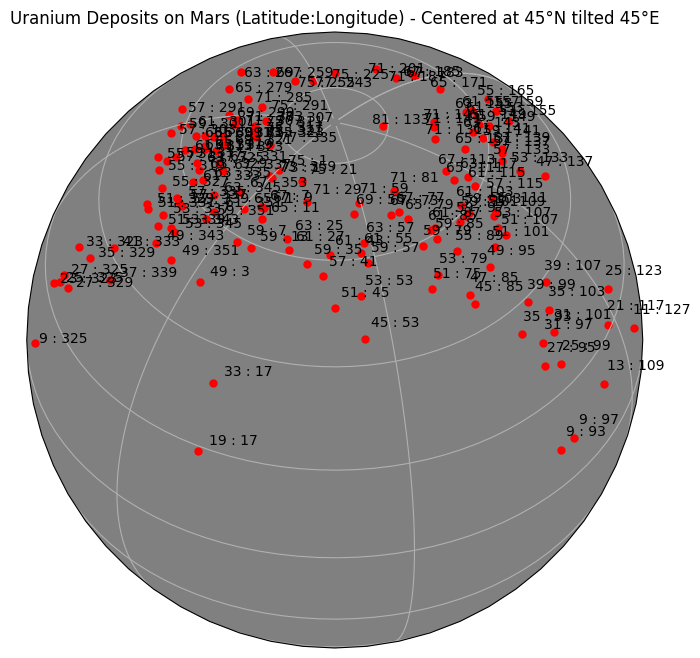

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig = plt.figure(figsize=(10, 8))

# Adjust central latitude and add a tilt to the right
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=45, central_latitude=45))  # Centered at 45N, tilted 45 degrees East

# Set grey background
ax.set_facecolor('grey')

for point in marsData:
    ax.plot(
        point["lon"],
        point["lat"],
        "ro",
        markersize=5,
        transform=ccrs.Geodetic(),
    )
    ax.text(
        point["lon"] + 2,
        point["lat"] + 2,
        str(point["lat"]) + " : " + str(point["lon"]),
        transform=ccrs.Geodetic(),
    )

ax.set_global()
ax.gridlines()

plt.title("Uranium Deposits on Mars (Latitude:Longitude) - Centered at 45°N tilted 45°E")  # Updated title
plt.show()

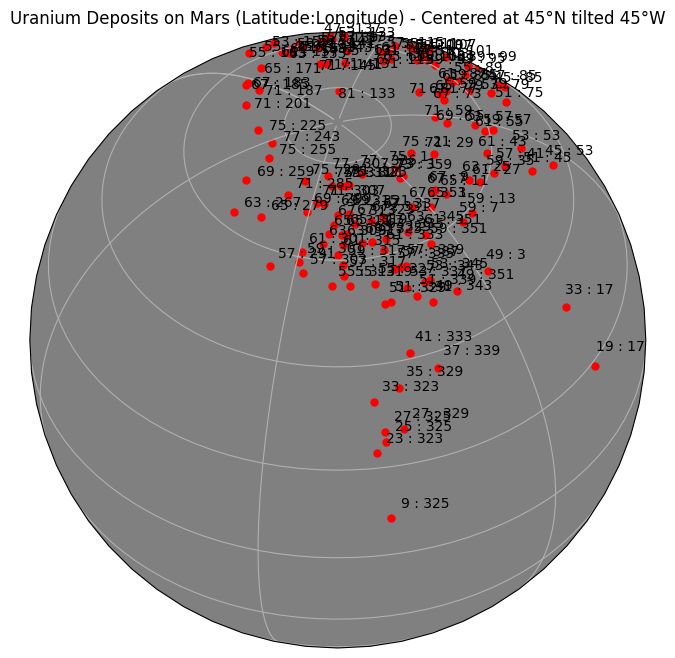

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig = plt.figure(figsize=(10, 8))

# Adjust central latitude and add a tilt to the left
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=-45, central_latitude=45))  # Centered at 45N, tilted 45 degrees West

# Set grey background
ax.set_facecolor('grey')

for point in marsData:
    ax.plot(
        point["lon"],
        point["lat"],
        "ro",
        markersize=5,
        transform=ccrs.Geodetic(),
    )
    ax.text(
        point["lon"] + 2,
        point["lat"] + 2,
        str(point["lat"]) + " : " + str(point["lon"]),
        transform=ccrs.Geodetic(),
    )

ax.set_global()
ax.gridlines()

plt.title("Uranium Deposits on Mars (Latitude:Longitude) - Centered at 45°N tilted 45°W")
plt.show()

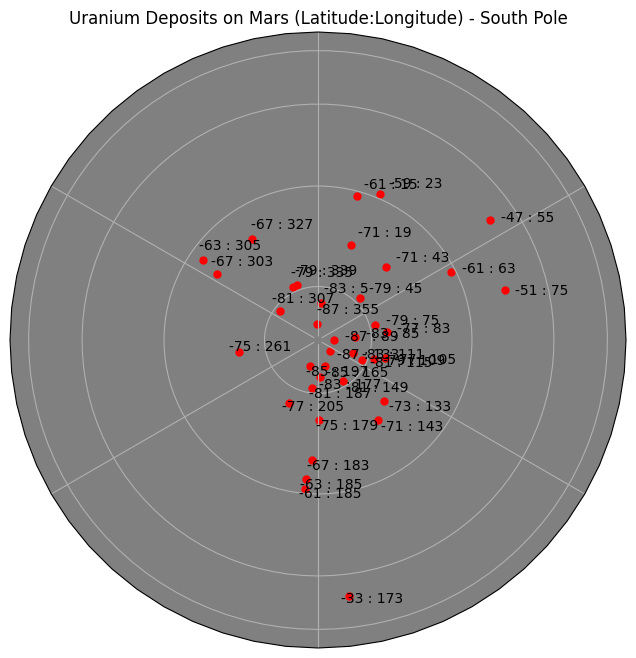

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig = plt.figure(figsize=(10, 8))

# Center the projection on the South Pole
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_latitude=-90))

# Set grey background
ax.set_facecolor('grey')

for point in marsData:
    ax.plot(
        point["lon"],
        point["lat"],
        "ro",
        markersize=5,
        transform=ccrs.Geodetic(),
    )
    ax.text(
        point["lon"] + 2,
        point["lat"] + 2,
        str(point["lat"]) + " : " + str(point["lon"]),
        transform=ccrs.Geodetic(),
    )

ax.set_global()
ax.gridlines()

plt.title("Uranium Deposits on Mars (Latitude:Longitude) - South Pole")  # Updated title
plt.show()

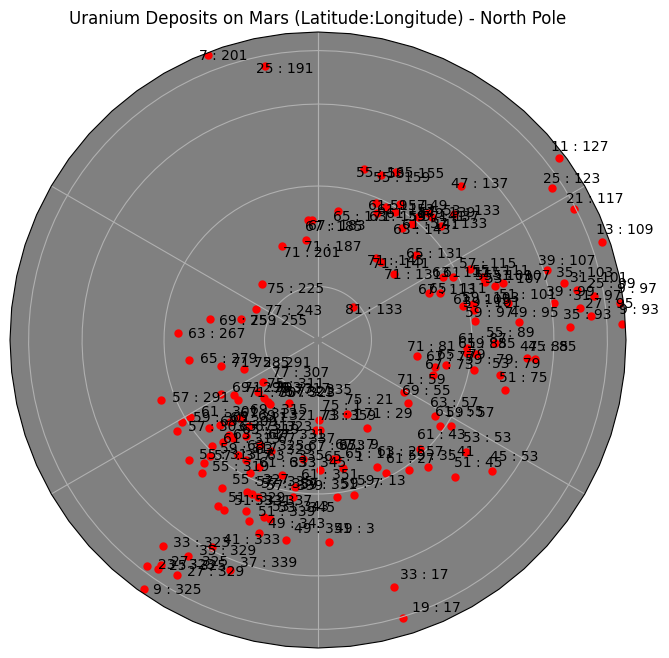

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig = plt.figure(figsize=(10, 8))

# Center the projection on the North Pole
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_latitude=90))

# Set grey background
ax.set_facecolor('grey')

for point in marsData:
    ax.plot(
        point["lon"],
        point["lat"],
        "ro",
        markersize=5,
        transform=ccrs.Geodetic(),
    )
    ax.text(
        point["lon"] + 2,
        point["lat"] + 2,
        str(point["lat"]) + " : " + str(point["lon"]),
        transform=ccrs.Geodetic(),
    )

ax.set_global()
ax.gridlines()

plt.title("Uranium Deposits on Mars (Latitude:Longitude) - North Pole")  # Updated title
plt.show()